# MountainCar

Exploring the `MountainCar-v0` environment from the Open Gym 

## Import libraries and create an environment

In [45]:
import numpy as np
import matplotlib.pyplot as plt

import gym                                      # OpenAI Gym library
env = gym.make('MountainCar-v0')                # create an environment

## Show initial state

- On Windows, the render window will pop up on top of the browser only if it is not maximized to full screen (slightly **reduce the browser window**). 
- You can close the render window only by executing the command `env.close()`.

obs: [-0.46292958  0.        ]


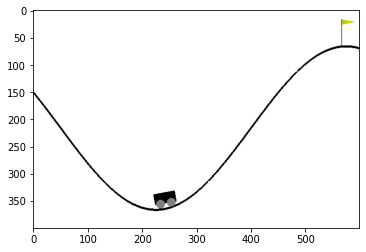

In [46]:
obs = env.reset()                               # initial observation on the system

print('obs:', obs) 
plt.imshow(env.render('rgb_array'))             # render the environment as image 

In [47]:
env.close()                                       # сlose render window

## Environment properties

In [48]:
space = env.observation_space                     # observation space
print("space: ", space.shape, space.dtype)        # space dimension and type
print("low:   ", space.low)                       # minimum values
print("high:  ", space.high)                      # maximum values

actions = env.action_space                        # action space
print("actions:", actions.n, actions.dtype)       # number of actions, type

space:  (2,) float32
low:    [-1.2  -0.07]
high:   [0.6  0.07]
actions: 3 int64


In [49]:
obs = env.reset()                                 # initial observation on the system
for i in range(1000):                             # 1000 time steps
    action = 2                                    # always right
    obs, rew, done, _ = env.step(action)          # take action and get information
    env.render()                                  # draw the environment
env.close()                                       # сlose render window

## Reward Statistics

In [55]:
def policy(state):
    return 2*int(state[1] > 0)                    # push towards speed

def run(ticks = 500):
    tot_rew = 0                                   # total reward    
    state = env.reset()                           # start state
    for t in range(1,ticks+1):       
        action = policy(state)                    # select action
        state, rew, done, _ = env.step(action)    # get inforamtion    
        tot_rew += rew         
        if done:                                  # end of episode
            break
            
    return tot_rew                                

def statistics(episodes = 1000, ticks = 200):
    rews = np.empty(episodes)                      # rewards in each episode 
    
    for episode in range(episodes):                
        rews[episode] = run()
        
    mean, std = rews.mean(), rews.std()            
    print(f"rew = {mean:.1f} ± {std/len(rews)**0.5 : .0f} [{rews.min():.0f}...{rews.max():.0f}] std = {std:.0f}")
    
    return mean, std                               

In [56]:
statistics(episodes=1000, ticks=200)

rew = -129.5 ±  1 [-200...-86] std = 33


(-129.475, 33.27280233163417)

## Save Video

In [66]:
from PIL import Image, ImageDraw, ImageFont
import imageio

def render_frame(frame, text: str):
    """
    Get frame with overwritten text:
    """
    im = Image.fromarray(frame)
    if text:        
        drawer = ImageDraw.Draw(im)    
        text_color = (255,255,255) if np.mean(im) < 128 else (0,0,0)
        font = ImageFont.truetype("verdana.ttf", 18)
        drawer.text((10, 10), text, fill=text_color, font=font)        
        font = ImageFont.truetype("verdana.ttf", 14)
        drawer.text((im.size[0]-100,im.size[1]-20), "QuData.com", fill=text_color, font=font)
    return im


frames, last = [], 0
for episode in range(1, 11):
    rew = 0
    s = env.reset()                        
    for t in range(200):       
        a = policy(s)                 
        s, r, done, _ = env.step(a) 
        rew += r
        
        if done:
            last = rew

        frame = env.render(mode='rgb_array') 
        #frame = render_frame(frame, f"{episode:2d}:  a=2  <rew> = -200 [-200...-200]  {last:4.0f}")
        #frame = render_frame(frame, f"{episode:2d}:  a=2*int(s[1]>0)  <rew> = -130 [-200...-86]  {last:4.0f}")
        frame = render_frame(frame, f"{episode:2d}:  a=NN(2,32,64,1)  <rew> =  -98.2  [-108...-83]  {last:4.0f}")        
        frames.append(frame)
    
        if done:              
            break                

imageio.mimwrite("render.mp4", frames, fps=60)            
env.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Best Solution

In [62]:
import datetime
import torch
import torch.nn as nn

state = torch.load('MountainCar_2_32_64_1.98.1.pt')  
print(state['info'])
print(state['date'])
print(state['model'])

nH = [32, 64]
model = nn.Sequential(           
           nn.Linear(2, nH[0]),    
           nn.Sigmoid(),         
           nn.Linear(nH[0], nH[1]),  
           nn.Sigmoid(),         
           nn.Linear(nH[1], 1),  
           nn.Sigmoid() )      

model.load_state_dict(state['state']) 

def policy(obs, level=0.05):
    with torch.no_grad():    
        x = torch.tensor(obs, dtype=torch.float32)
        y = model(x)                
    if y > 0.5 + level:
        return 2
    if y < 0.5 - level:
        return 0            
    return 1            

MountainCar best solution. Reward: -98.2  [-108...-83] std = 7
2022-06-13 11:55:40.431447
Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=64, out_features=1, bias=True)
  (5): Sigmoid()
)


## Plotting of machine trajectories

In [ ]:
class MountainCar:
    def __init__(self, goal_velocity=0):
        self.min_position  = -1.2
        self.max_position  = 0.6
        self.max_speed     = 0.07
        self.goal_position = 0.5
        self.goal_velocity = goal_velocity

        self.low  = np.array([self.min_position, -self.max_speed], dtype=np.float32)
        self.high = np.array([self.max_position,  self.max_speed], dtype=np.float32)

        self.force   = 0.001
        self.gravity = 0.0025        

    def step(self, action: int):
        position, velocity = self.state

        velocity += (action - 1) * self.force + math.cos(3 * position) * (-self.gravity)
        velocity = np.clip(velocity, -self.max_speed, self.max_speed)
        position += velocity
        position = np.clip(position, self.min_position, self.max_position)
        if position == self.min_position and velocity < 0:
            velocity = 0

        done = bool(position >= self.goal_position and velocity >= self.goal_velocity)

        self.state = (position, velocity)
        return np.array(self.state, dtype=np.float32), done

In [ ]:
env = MountainCar()
X, V = [], []

m = -math.pi/6
startX = np.array([    m, m,     m,      m,    m,   m, m,  m,  m])  #np.linspace(-0.6, 0.5, 10)
startV = np.array([ 0.07, 0.06, 0.05,  0.04,  0.03, 0.02, -0.04, -0.05, -0.06])  #np.full( (len(startX),),  0.07)

for i in range(len(startX)):
    x, v = startX[i], startV[i]
    X.append([])
    V.append([])
    X[-1].append(x)
    V[-1].append(v)
    env.state = (x, v)
    for _ in range(200):
        obs, done = env.step(1)     # сделать действие и получить информацию
        x, v = obs
        X[-1].append(x)
        V[-1].append(v)
        if done:
            break
        env.state = obs



plt.figure(figsize=(8,8)) 
plt.xlim(-1.2, 0.6)
plt.ylim(-0.07, 0.07)
plt.axhline(0, linestyle='--', c='black', linewidth=1)
plt.axvline(0.5, linestyle='--', c='black', linewidth=1)
plt.axvline(-math.pi/6, linestyle='--', c='black', linewidth=1)
plt.xlabel(r'$x$',  {'fontsize': 16})  
plt.ylabel(r'$v$',  {'fontsize': 16}) 
plt.title ('a=1',   {'fontsize': 16})

for i in range(len(X)):
    plt.plot    (X[i], V[i], linewidth=0.5)   
    plt.scatter (X[i], V[i], s=10)  
    plt.scatter (X[i][0], V[i][0], color="black", s=30)  

plt.show()


## Visualization

In [ ]:
def draw_text(frame, text = ""):
    """ Get frame with overwritten text """
    im = Image.fromarray(frame)    
    drawer = ImageDraw.Draw(im)    
    text_color = (255,255,255) if np.mean(im) < 128 else (0,0,0)
    font = ImageFont.truetype("arial.ttf", 24)    
    drawer.text((5, 5), text, fill=text_color, font=font)
    font = ImageFont.truetype("arial.ttf", 12)    
    drawer.text(((im.size[0]-130, im.size[1]-16)), "QuData.com", fill=text_color, font=font)
    return im

def plt_to_array(fig):
    """ Get array from figure of plt """
    buf = io.BytesIO()
    fig.savefig(buf, format='raw')
    buf.seek(0)
    arr = np.reshape(np.frombuffer(buf.getvalue(), dtype=np.uint8),
                     newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
    buf.close()    
    return arr

def add_frame(text):    
    """ Add frame to frames list """
    fig = plt.figure(figsize=(16,4))    
    for i in range(4):                    
        plt.subplot(1, 4, i+1)
        plt.title (['LEFT <','DOWN v', 'RIGHT >',  'UP ^'][i]) 
        cmap =  ListedColormap(["white", "gray"])                  # "Greys"
        sns.heatmap(Q[:, i].reshape(4,-1), annot=True, cbar=False, square=True, vmin=0, vmax=1., cmap="Greys")

    frames.append( draw_text( plt_to_array(fig), text) )
    plt.close()

In [118]:
a = np.array([[1,3],[2,1],[3,2]])

a = a[a[:, -1].argsort()[::-1]]

a

array([[1, 3],
       [3, 2],
       [2, 1]])